[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab10_diffusion.ipynb)

# Denoising Diffusion Probabilistic Models (DDPM)

## Description

In this lab, we train an image generation model using diffusion. Diffusion is just one of several techniques to generate images, but it has recently surpassed the GAN as the state-of-the-art generation model.

The diffusion model is trained to remove noise from images, and once it is fully trained it can take random noise and fully "denoise" it into an image that looks reasonably like the training set.

## Objectives
- Implement forward process of diffusion
- Implement backward process of diffusion
- Generate images with the diffusion process
- Answer questions about diffusion

## Grading Criteria
- Scheduling (10%)
- Forward Diffusion (30%)
- Backward Diffusion (30%)
- Image Generation (20%)
- Answers to Questions (10%)

### Helpful Reading
- Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
- Improved Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2102.09672



In [1]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Hyperparameters
MAX_TIMESTEPS = 1000
image_size = 32
lr = .0001

We have given you a simpler version of the UNet used in "Improved Denoising Diffusion Probabilistic Models." Feel free to familiarize yourself with the model. It is similar to the UNet we made in the cancer detection lab, but has layers that incorporate the timestep embedding. The model is already fully implemented.

In [3]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


# Note: this is an abstract method, do not implement `forward`
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)


# Part 1: Implement a linear and cosine scheduler

A scheduler is an important aspect to training a diffusion model. The scheduler returns a sequence of $\beta$ values, i.e. $[\beta_1, \cdots, \beta_T]$, that help determine how much noise is added to an image for training (forward process) and is removed from an image for inference (backward process). While the linear and cosine beta schedulers are valid ways of computing $\beta$s, the cosine scheduler is a better choice. Both schedulers should return 1-D tensors containing $[\beta_1, \cdots, \beta_T]$.

While we will only use t=1...T in training, we will need $\bar{\alpha}_0=1$ in the sampling function. To ensure $\bar{\alpha}_0 = 1$, you should prepend your list of $\beta$ with $\beta_0 = 0$. This will also ensure your indices match up with PyTorch's 0-indexed tensors.

**Tip:** Implement and use the linear beta scheduler first while you debug your diffusion model. Once you know your model works, then you can switch to the cosine scheduler for better results.

In [9]:
def linear_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] linearly. Discussed in "Denoising Diffusion Probabilistic Models"
    Example values for β1, βT shown in 1st bullet point of Appendix B.
    """
    b1 = 1e-4
    b_t = 0.02

    betas = torch.linspace(b1, b_t, timesteps)
    betas = torch.cat([torch.tensor([0.0]), betas])  # add 0 to front to make indexes align

    return betas


def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    s = 0.008
    steps = timesteps + 1

    t = torch.linspace(0, timesteps, timesteps + 1)
    f_t = torch.cos(((t / timesteps + s) / (1 + s)) * np.pi / 2) ** 2

    alpha_bar = f_t / f_t[0]
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    beta_values = torch.clip(betas, max=0.999)

    betas = torch.cat([torch.tensor([0.0]), betas])  # add 0 to front to make indexes align
    return betas


# test linear_beta_schedule
# betas = linear_beta_schedule(1000)
# print(betas.shape)
# print(betas[0])
# print(betas[1])
# print(betas[-1])

# betas = cosine_beta_schedule(1000)
# print(betas.shape)
# print(betas[0])
# print(betas[1:5])

It would be helpful to compute global variables for $\beta$, $\alpha$, and $\bar{\alpha}$ down below so you don't need to recompute them for the forward and backward process. $\alpha$ and $\bar{\alpha}$ are defined right above equation 4 in "Denoising Diffusion Probability Models."

Note that the cosine schedule uses $\bar{\alpha}$ to compute $\beta$. But since we clip $\beta$ after deriving it, you should recompute $\bar{\alpha}$ from $\alpha$ and the clipped $\beta$.

In [10]:
def compute_alpha(beta):
  return 1 - beta

def compute_alpha_bar(alpha):
  return torch.cumprod(alpha, dim=0)

Compute values for both schedulers.

In [11]:
lin_betas = linear_beta_schedule(MAX_TIMESTEPS)
cos_betas = cosine_beta_schedule(MAX_TIMESTEPS)

lin_alpha = compute_alpha(lin_betas)
lin_alpha_bar = compute_alpha_bar(lin_alpha)

cos_alpha = compute_alpha(cos_betas)
cos_alpha_bar = compute_alpha_bar(cos_alpha)

Figure 5 of "Improved Denoising Diffusion Probabilistic Models" graphs the $\bar{\alpha}$ schedule. Graph both your $\bar{\alpha}$ schedulers to verify your schedulers are correct.

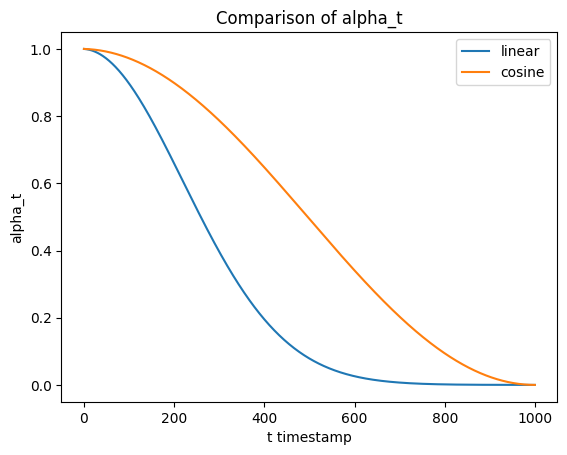

In [12]:
plt.plot(lin_alpha_bar.numpy(), label='linear')
plt.plot(cos_alpha_bar.numpy(), label='cosine')
plt.xlabel("t timestamp")
plt.ylabel("alpha_t")
plt.title("Comparison of alpha_t")
plt.legend()
plt.show()

Select which scheduler to use. To prevent broadcasting images, reshape all three lists to (T, 1, 1, 1). Put the tensors on the device, and if you used NumPy to create the tensors, convert from double to floats.

In [13]:
betas = cos_betas
alpha = cos_alpha
alpha_bar = cos_alpha_bar

betas = betas.view(MAX_TIMESTEPS + 1, 1, 1, 1).to(device).float()
alpha = alpha.view(MAX_TIMESTEPS + 1, 1, 1, 1).to(device).float()
alpha_bar = alpha_bar.view(MAX_TIMESTEPS + 1, 1, 1, 1).to(device).float()

# Part 2: Implement the forward diffusion (training) process

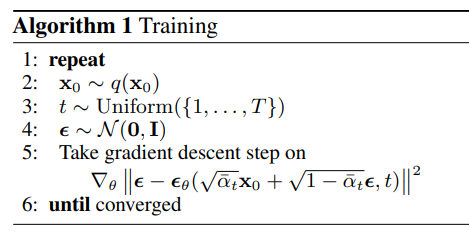

While you might be accustomed to pseudocode, deep learning pseudocode can sometimes be difficult to parse in the beginning and so we will explain all the steps here. The first thing to note is that **there is an implicit batch dimension included in the pseudocode**, so do not interpret this training loop as operating on a single image.

Line 2: Sample a batch of images $x_0$ from you dataset of images $q$. The subscript $0$ denotes the current timestep $t$, i.e. $x_{t=0} \equiv x_0$.

Line 3: Sample from the uniform distribution a batch of timesteps between 1 and $T$. The timesteps in the batch do not need to match.

Line 4: Sample noise from the normal distribution. In line 5 we see that the noise is going to be subtracted and multiplied element-wise to our batch of images. This means that the shape of the noise needs to match the shape of the batch of images, i.e. noise.shape = images.shape = (B, C, H, W).

Line 5: There is an implicit $x_t$ being created here where $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$. Therefore, $x_t$ and $t$ are passed into our diffusion model $\epsilon_{\theta}$. The model's goal is to predict the noise $\epsilon$ that was added into the model. $\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert^2$ is our loss and it means to take the mean squared error between $\epsilon$ and our model's prediction of $\epsilon$. The final two parts of line 5 are $\nabla_{\theta}$ and "take the gradient descent step" which translates into pytorch as call `loss.backward()` and `optimizer.step()` respectively.

Lines 1 and 6 mean to continually train your model until there is no improvement.

In [14]:
def training(model, optimizer, dataloader, n_minibatches=1500):
    model.train()  # Let's the model know it is in training mode
    losses = []

    T = alpha_bar.shape[0] - 1
    for i, batch in enumerate(dataloader):
        if i > n_minibatches:
            break

        x0 = batch[0].to(alpha_bar.device)
        B = x0.shape[0]

        t = torch.randint(1, T, (B,), device=alpha_bar.device)

        alpha_bar_t = alpha_bar[t].view(B, 1, 1, 1)

        noise = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

        predicted_noise = model(x_t, t)

        loss = F.mse_loss(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if i % 100 == 0:
            print(f"Loss at step {i}: {loss.item()}")

    return losses

    # Implement Algorithm 1 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    # 1000-2000 minibatches (i.e. optimization steps) is sufficient for learning how to generate images, but more will help make better images

# Part 3: Implement the backward diffusion (sampling) process

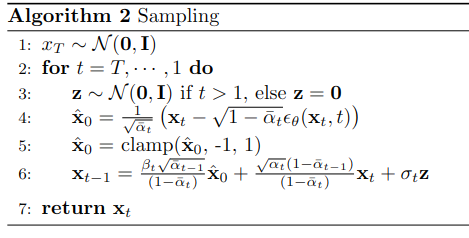

where $\bar{\alpha}_0 = 1$ and $\sigma_t = \sqrt{\beta_t}$.

**Note:** the only time $\alpha_t$ (without bar) is used instead of $\bar{\alpha}_t$ (with bar) is under the square root in the second term on line 6 (the numerator multiplied by $x_t$). If you mix up $\alpha$ and $\bar{\alpha}$, your sampling will not work!

In [36]:
@torch.no_grad()
def sampling(model, batch_size):
    model.eval()
    image_size = (1, 32, 32)

    x_t = torch.randn(batch_size, *image_size).to(device)

    for t in reversed(range(1, MAX_TIMESTEPS + 1)):
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        eps_theta = model(x_t, t_tensor)

        sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(1, 1, 1, 1)

        x0_hat = (x_t - sqrt_one_minus_alpha_bar_t * eps_theta) / sqrt_alpha_bar_t
        x0_hat = torch.clamp(x0_hat, -1.0, 1.0)

        z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)

        beta_t = betas[t].view(1, 1, 1, 1)
        alpha_t = alpha[t].view(1, 1, 1, 1)
        alpha_t_prev = alpha[t - 1].view(1, 1, 1, 1)
        alpha_bar_t = alpha_bar[t].view(1, 1, 1, 1)
        alpha_bar_t_prev = alpha_bar[t - 1].view(1, 1, 1, 1)

        coef1 = (beta_t * torch.sqrt(alpha_bar_t_prev)) / (1 - alpha_bar_t)
        coef2 = (torch.sqrt(alpha_t) * (1 - alpha_bar_t_prev)) / (1 - alpha_bar_t)
        sigma_t = torch.sqrt(beta_t)

        x_t = coef1 * x0_hat + coef2 * x_t + sigma_t * z

    return x_t

# Part 4: Train and generate images

In [16]:
preprocess_transform = Compose([
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

In [17]:
model = UNetModel(
        in_channels=1,
        hidden_channels=32,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 24
dataset = torchvision.datasets.MNIST("data/", train=True, download=True, transform=preprocess_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.62MB/s]


In [18]:
train_losses = training(model, optimizer, dataloader)

Loss at step 0: 1.003941297531128
Loss at step 100: 0.32130706310272217
Loss at step 200: 0.07463382184505463
Loss at step 300: 0.06389565020799637
Loss at step 400: 0.06215418875217438
Loss at step 500: 0.030390102416276932
Loss at step 600: 0.04080052301287651
Loss at step 700: 0.043423622846603394
Loss at step 800: 0.037539076060056686
Loss at step 900: 0.03039129450917244
Loss at step 1000: 0.03791850432753563
Loss at step 1100: 0.03082846663892269
Loss at step 1200: 0.041760873049497604
Loss at step 1300: 0.027213817462325096
Loss at step 1400: 0.02884133905172348
Loss at step 1500: 0.050357669591903687


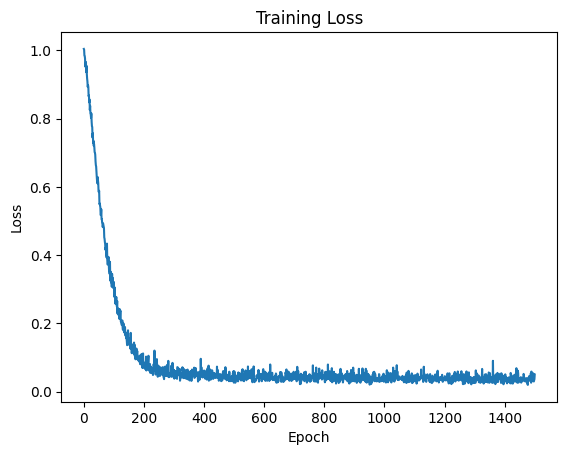

In [20]:
# plot your training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

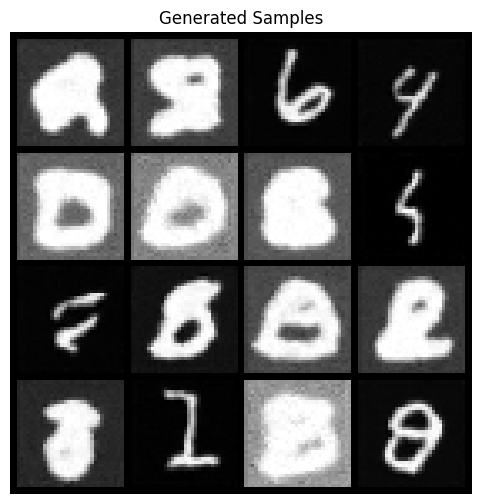

In [37]:
# Use sampling() to generate 16 images and plot them below
import torchvision.utils as vutils

samples = sampling(model, batch_size=16)
samples = (samples.clamp(-1, 1) + 1) / 2
grid = vutils.make_grid(samples, nrow=4)

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Generated Samples")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

# Part 5: Questions

1. Where do we scale the values of our training data? What range do we scale the data to? Why do we scale the data in that range?

2. Why is the cosine scheduler better than the linear scheduler?

This is due to the cosine adding more noise more slowly at the beginning so that our model is learning from a clearer image early on, as compared with linear scheduler.

3. In the forward step, we perform a random number of denoising steps in one forward pass, but in the backward process, we have to perform T forward passes to generate images. Why is that?

4. What is our network learning to predict?

it is learning to predict the noise that was add at timestep t.

5. If we wanted to perform conditional generation; for example, if we wanted to provide our network with a digit and have it produce an image of that digit, what would we have to change?

we would have to use label for each class. We would also have to use an encoder.